In [37]:
import pandas as pd
import numpy as np

data_location = "../data/data_prepared.pkl"


In [38]:
output_shape = 77
raw_data = pd.read_pickle(data_location).astype(float)
raw_data = raw_data.iloc[:,:output_shape]

In [39]:
raw_data.shape

(2945, 77)

In [40]:
from sklearn. preprocessing import StandardScaler
def generate_time_features(X):
        # hour, month, day, dayOfWeek, ISvacation,  ISweekend
        X = X.copy()
        X["Hour"] = X.index.hour
        X["Month"] = X.index.month
        X["Day"] = X.index.day
        X["weekday"] = X.index.weekday
        X["IsWeekend"] = np.array(map(lambda i:0 if i <5 else 1,X.index.weekday))
        return X
features = generate_time_features(raw_data).astype(float)
features  = features/np.mean(features,axis= 0)
targets = raw_data.astype(float)

In [41]:
features.shape, targets.shape

((2945, 82), (2945, 77))

In [42]:
import keras
sampling_rate = 1
sequence_length = 168
forecast_steps = 1
delay = sampling_rate * (sequence_length + forecast_steps - 1)
batch_size = 128



In [43]:
num_row = raw_data.shape[0] - delay
num_train_samples = int(0.8 * num_row)
num_val_samples = int(0.1 * num_row)
num_test_samples = num_row- num_train_samples - num_val_samples

In [44]:
train_dataset = keras.utils.timeseries_dataset_from_array(
    features.iloc[:-delay,:],
    targets=targets.iloc[delay:,:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)
  
val_dataset = keras.utils.timeseries_dataset_from_array(
    features.iloc[:-delay,:],
    targets=targets.iloc[delay:,:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)
  
test_dataset = keras.utils.timeseries_dataset_from_array(
    features.iloc[:-delay,:],
    targets=targets.iloc[delay:,:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [45]:
for inputs, targets in train_dataset:
    print(inputs.shape, targets.shape)

(128, 168, 82) (128, 77)
(128, 168, 82) (128, 77)
(128, 168, 82) (128, 77)
(128, 168, 82) (128, 77)
(128, 168, 82) (128, 77)
(128, 168, 82) (128, 77)
(128, 168, 82) (128, 77)
(128, 168, 82) (128, 77)
(128, 168, 82) (128, 77)
(128, 168, 82) (128, 77)
(128, 168, 82) (128, 77)
(128, 168, 82) (128, 77)
(128, 168, 82) (128, 77)
(128, 168, 82) (128, 77)
(128, 168, 82) (128, 77)
(128, 168, 82) (128, 77)
(6, 168, 82) (6, 77)


In [46]:
n = 0
for inputs, targets in train_dataset:
    print(inputs[1,:,0])
    print(targets[0,0])
    if n>=1:
        break
    n+=1

tf.Tensor(
[0.         0.08895668 0.14826114 0.11860891 0.26687005 0.80061016
 0.71165348 0.85991462 0.65234902 0.62269679 1.27504581 1.77913369
 2.43148271 2.01635152 2.16461266 1.77913369 0.         0.
 0.         0.         0.         0.         0.         0.11860891
 0.2075656  0.32617451 0.53374011 0.32617451 0.50408788 0.9488713
 0.91921907 0.9488713  1.09713244 1.1564369  1.03782799 1.74948146
 1.98669929 2.75765722 2.37217826 0.02965223 0.         0.
 0.         0.         0.         0.         0.         0.02965223
 0.08895668 0.26687005 0.59304456 0.56339234 0.41513119 0.62269679
 0.88956685 0.97852353 0.9488713  1.33435027 1.66052478 2.34252603
 2.90591836 1.83843815 1.8977426  0.08895668 0.         0.
 0.         0.         0.         0.         0.         0.05930446
 0.08895668 0.32617451 0.44478342 0.59304456 1.27504581 1.00817576
 1.27504581 1.74948146 2.1053082  2.40183048 3.23209287 1.95704706
 1.74948146 2.04600375 1.48261141 0.         0.         0.
 0.         0.   

In [47]:
def get_predict_and_true(model,test_dataset):
    n = 0
    for inputs,targets in test_dataset:
        input_sample = inputs
        target_sample = targets
        n+=1
        if n>=1:
            break
    y_pred = model.predict(input_sample)
    y_true = target_sample
    return y_true, y_pred
import matplotlib.pyplot as plt
def calculate_smape(y_true, y_pred):
   
    #Ensure no division by zero
    epsilon = np.finfo(np.float64).eps
    
    # Calculate the absolute differences
    absolute_differences = np.abs(y_pred - y_true)
    
    # Calculate the denominators
    denominators = (np.abs(y_true) + np.abs(y_pred)) / 2 + epsilon
    
    # Calculate individual sMAPE values
    smape_values = (absolute_differences / denominators) 
    smape = np.mean(smape_values,axis=0) * 100

    return smape
def cal_metrics(y_true,y_pred):
    smape = calculate_smape(y_true,y_pred)
    mse = np.mean((y_pred - y_true)**2,axis = 0)
    mae = np.mean(np.abs(y_pred - y_true),axis=0)
    return [mse,mae,smape]

def plot_result(y_true,y_pred,area_index,model_name = "None"):
    y_pred[y_pred<1] = 0
    x = range(len(y_true))
    num_area = len(area_index)
    plot_index = 1
    plt.figure(figsize=(12,20))
    
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
    for i in area_index:
        area_predict = y_pred[:,i]
        area_true = y_true[:,i]
        area_name = raw_data.columns[i]

        metrics = cal_metrics(y_true,y_pred)
        area_diff = area_predict - area_true
        plt.subplot(num_area,1,plot_index)
        plt.title(f"{area_name} mse: {metrics[0][i]:.2f} mae: {metrics[1][i]:.2f} smape: {metrics[2][i]:.2f}")
        plt.plot(x,area_predict,label = "predict")
        plt.plot(x,area_true,label = "real")
        plt.plot(x,area_diff,label = "difference")
        plt.legend()

        plot_index +=1
    plt.tight_layout()
    plt.suptitle(model_name,y = 1.02)

    
    plt.show()


In [48]:
# Dense model
from tensorflow import keras 
from keras import layers
  
inputs = keras.Input(shape=(sequence_length, features.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(output_shape)(x)
model = keras.Model(inputs, outputs)
  
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",          
                                    save_best_only=True)
] 
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=val_dataset,
                    callbacks=callbacks)
  
model = keras.models.load_model("jena_dense.keras")
mse,mae = model.evaluate(test_dataset)
print(f"Test RMSE {np.sqrt(mse):.2f} Test MAE: {mae:.2f}")         
         
       

Epoch 1/100
17/17 [==============================] - 1s 30ms/step - loss: 141.7345 - mae: 5.5114 - val_loss: 14.0900 - val_mae: 1.5334
Epoch 2/100
17/17 [==============================] - 0s 13ms/step - loss: 81.1186 - mae: 4.2472 - val_loss: 8.6539 - val_mae: 1.4813
Epoch 3/100
17/17 [==============================] - 0s 13ms/step - loss: 59.3831 - mae: 3.7110 - val_loss: 5.8457 - val_mae: 1.2883
Epoch 4/100
17/17 [==============================] - 0s 12ms/step - loss: 43.9485 - mae: 3.1714 - val_loss: 4.7880 - val_mae: 1.1930
Epoch 5/100
17/17 [==============================] - 0s 11ms/step - loss: 35.2091 - mae: 2.9443 - val_loss: 5.2983 - val_mae: 1.2901
Epoch 6/100
17/17 [==============================] - 0s 11ms/step - loss: 41.1394 - mae: 2.9268 - val_loss: 5.3195 - val_mae: 1.2666
Epoch 7/100
17/17 [==============================] - 0s 11ms/step - loss: 25.7744 - mae: 2.4704 - val_loss: 4.9329 - val_mae: 1.1500
Epoch 8/100
17/17 [==============================] - 0s 11ms/step -

4/4 [==============================] - 0s 1ms/step


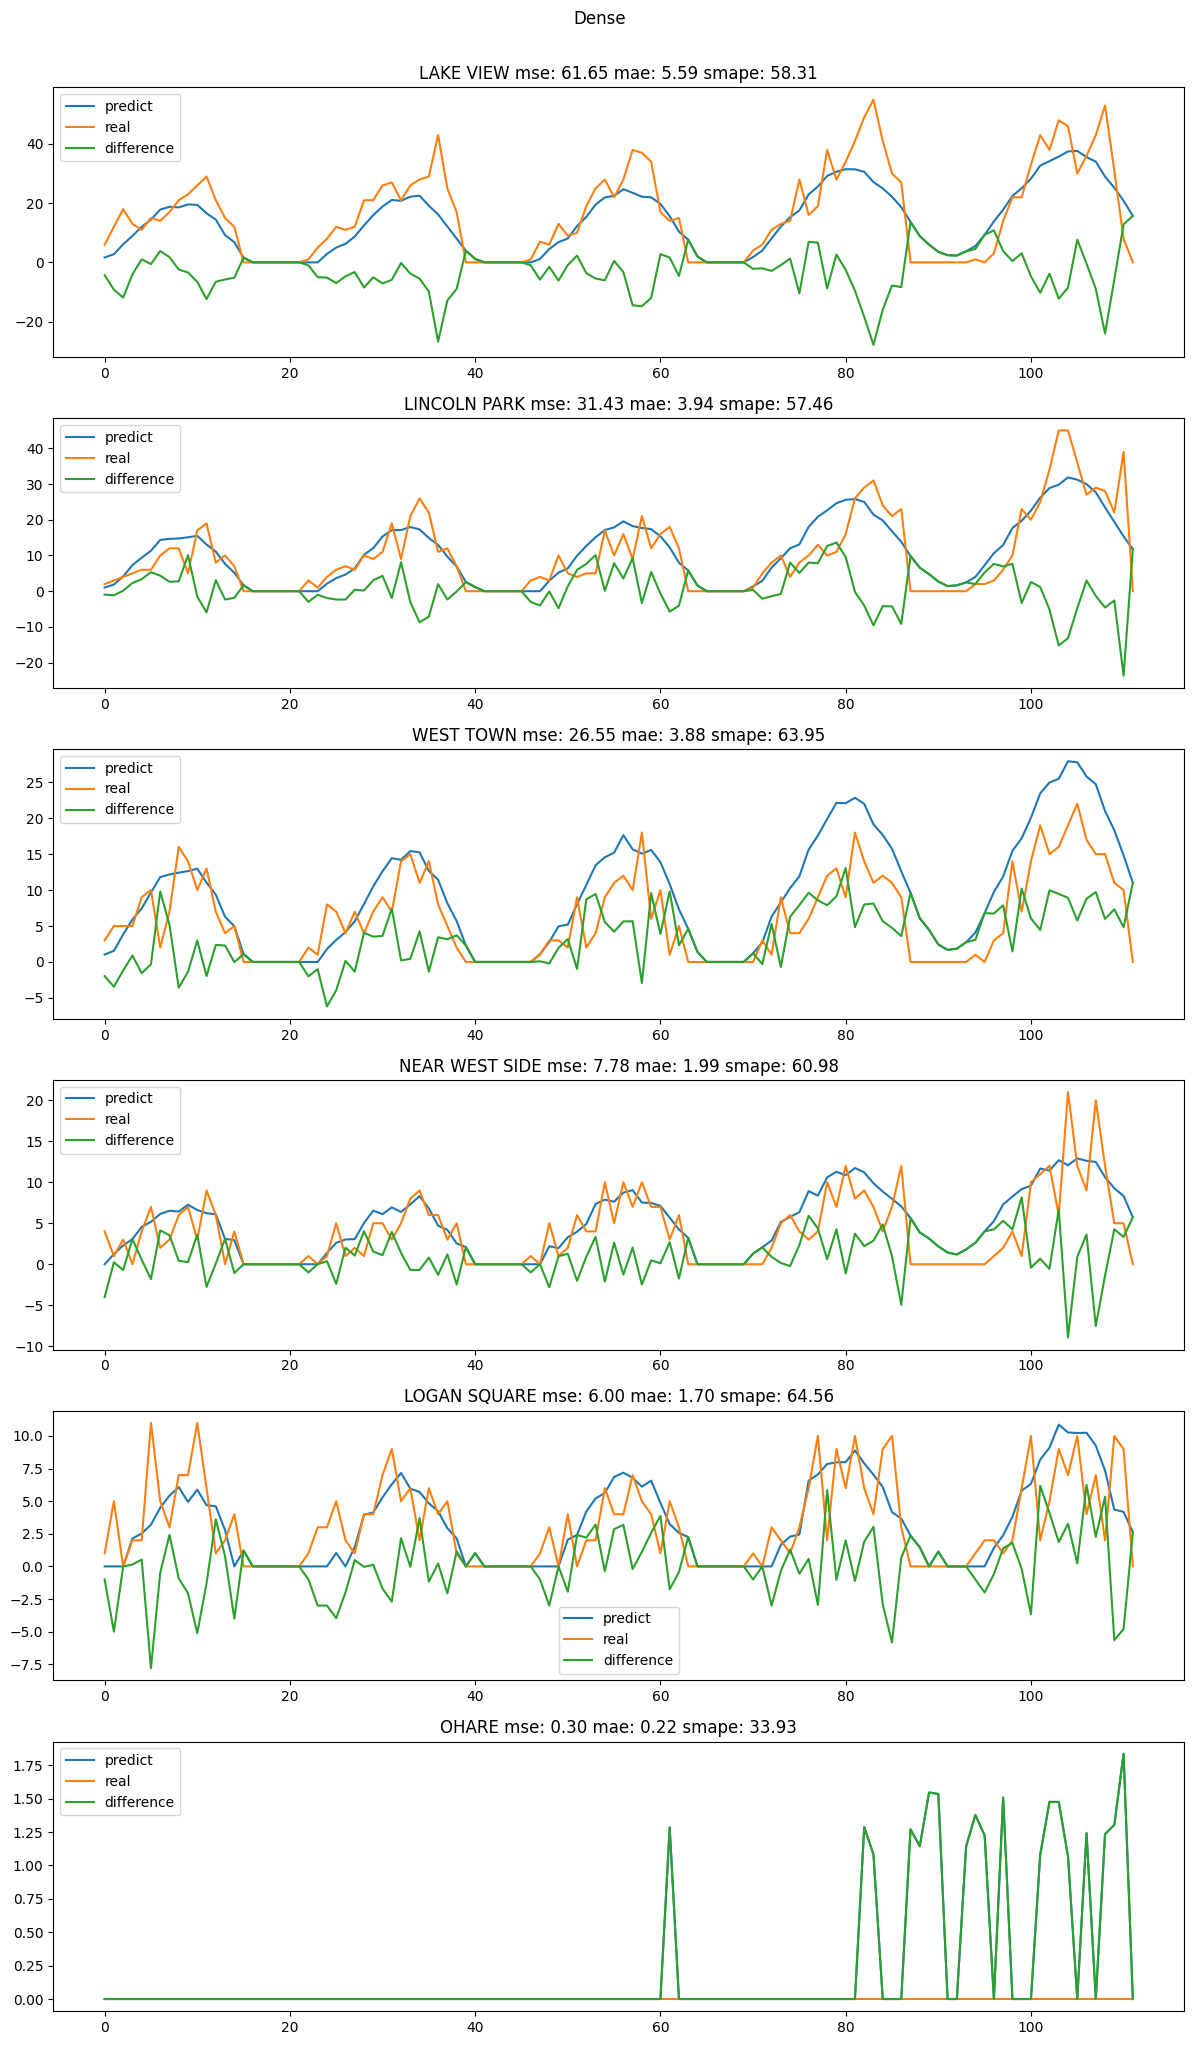

In [49]:
model.evaluate(test_dataset)
y_true, y_pred = get_predict_and_true(model, test_dataset)
plot_index = np.append(np.arange(5), -1)
plot_result(y_true,y_pred,plot_index,"Dense")  

In [50]:
# CONV 1D
inputs = keras.Input(shape=(sequence_length, features.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Flatten()(x)
outputs = layers.Dense(output_shape)(x)
model = keras.Model(inputs, outputs)
  
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=val_dataset,
                    callbacks=callbacks)
  
model = keras.models.load_model("jena_conv.keras")
mse,mae = model.evaluate(test_dataset)
print(f"Test RMSE {np.sqrt(mse):.2f} Test MAE: {mae:.2f}")

Epoch 1/100
17/17 [==============================] - 1s 34ms/step - loss: 135.7675 - mae: 4.0845 - val_loss: 17.7190 - val_mae: 1.7875
Epoch 2/100
17/17 [==============================] - 1s 31ms/step - loss: 96.2236 - mae: 4.0467 - val_loss: 14.8630 - val_mae: 1.8577
Epoch 3/100
17/17 [==============================] - 1s 31ms/step - loss: 86.1717 - mae: 3.8977 - val_loss: 14.2588 - val_mae: 1.8329
Epoch 4/100
17/17 [==============================] - 1s 32ms/step - loss: 82.2072 - mae: 3.7932 - val_loss: 13.7645 - val_mae: 1.8035
Epoch 5/100
17/17 [==============================] - 1s 31ms/step - loss: 77.5889 - mae: 3.7334 - val_loss: 12.9868 - val_mae: 1.7503
Epoch 6/100
17/17 [==============================] - 1s 31ms/step - loss: 70.4827 - mae: 3.5836 - val_loss: 11.8761 - val_mae: 1.6632
Epoch 7/100
17/17 [==============================] - 1s 31ms/step - loss: 61.1865 - mae: 3.3880 - val_loss: 10.7261 - val_mae: 1.5984
Epoch 8/100
17/17 [==============================] - 1s 31ms/

1/1 [==============================] - 0s 88ms/step - loss: 3.4034 - mae: 0.9650
Test RMSE 1.84 Test MAE: 0.97
4/4 [==============================] - 0s 2ms/step


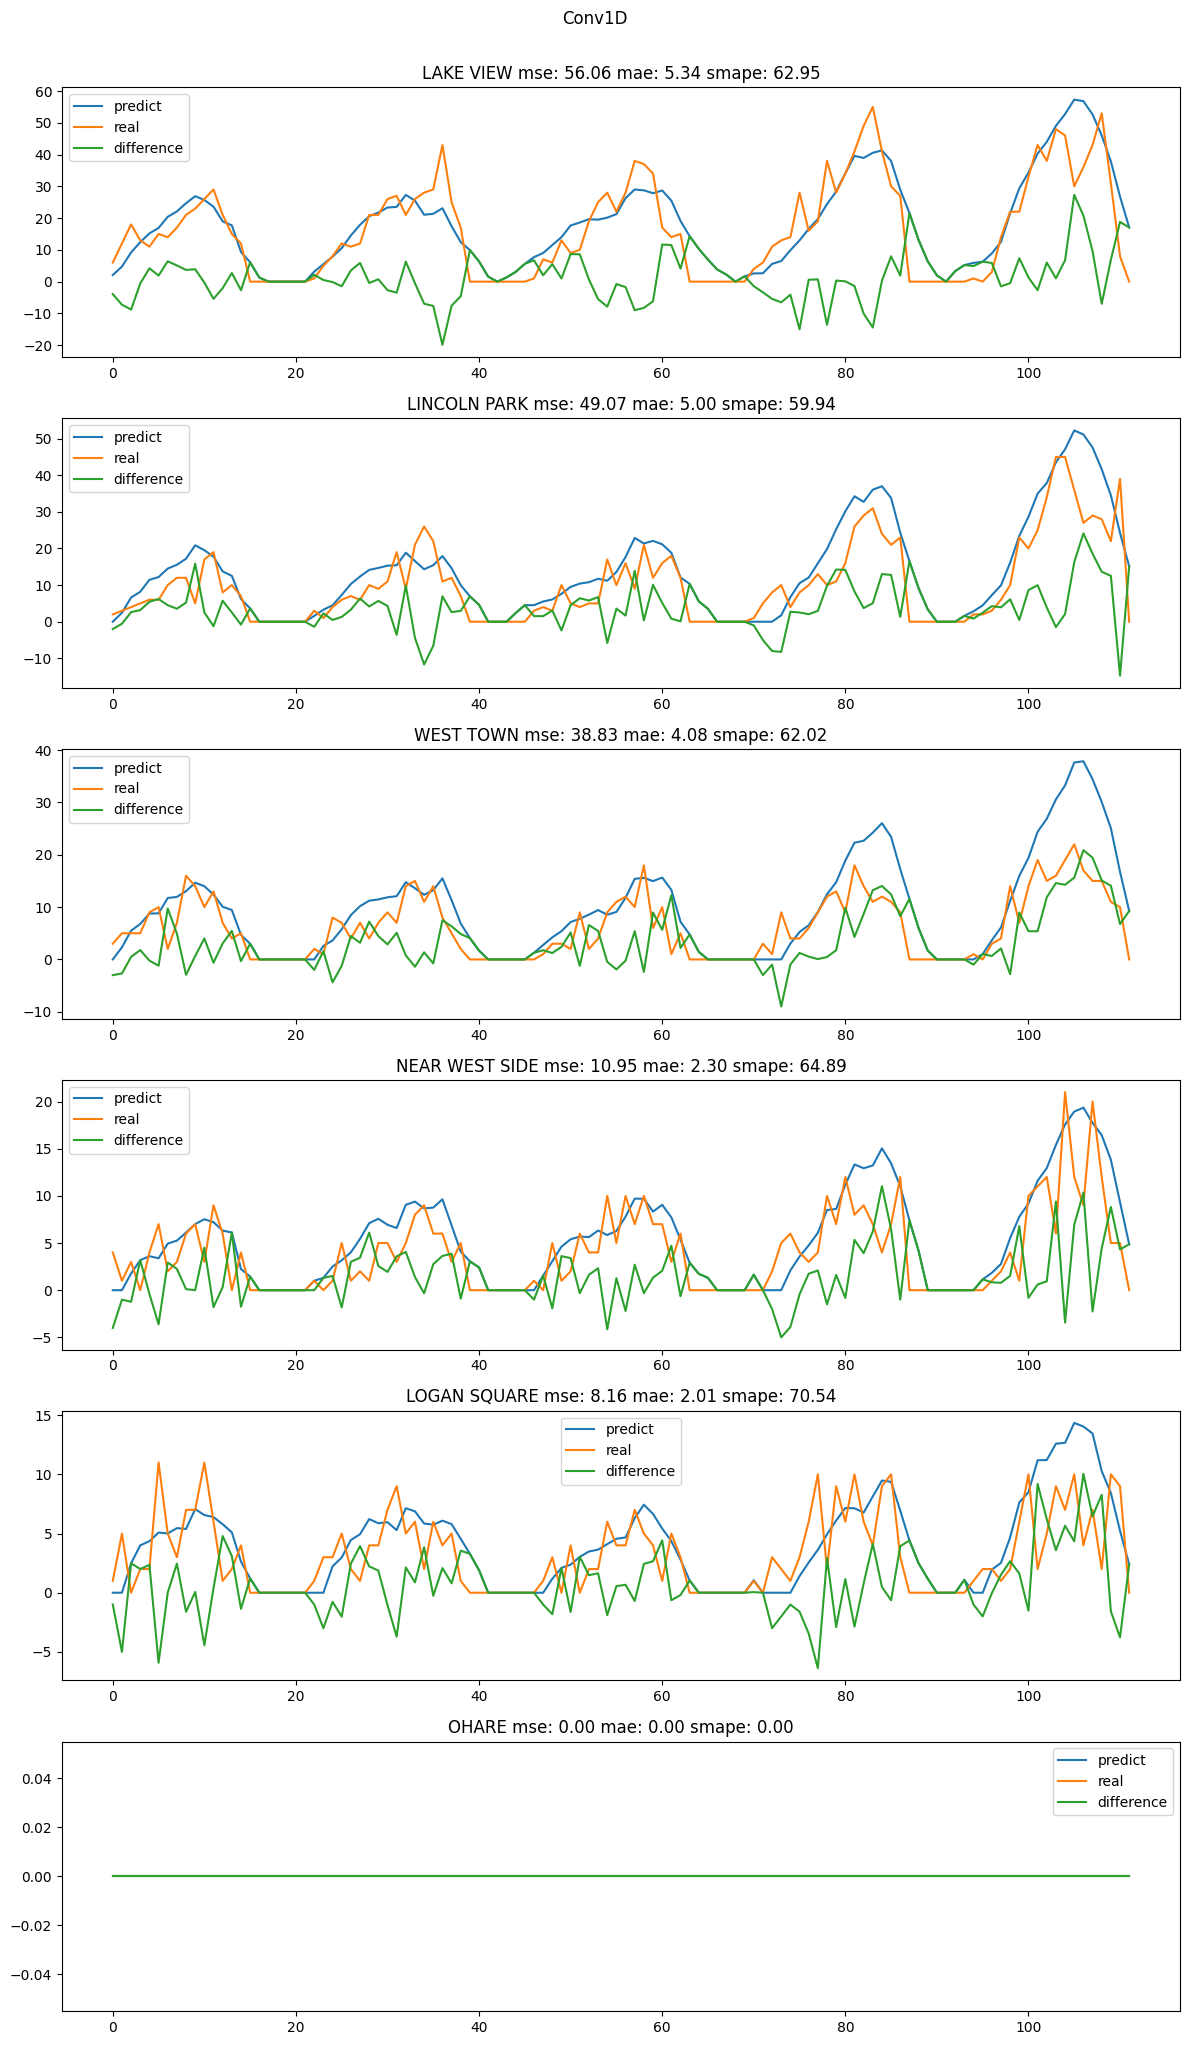

In [51]:
model = keras.models.load_model("jena_conv.keras")
mse,mae = model.evaluate(test_dataset)
print(f"Test RMSE {np.sqrt(mse):.2f} Test MAE: {mae:.2f}")
y_true, y_pred = get_predict_and_true(model, test_dataset)
plot_result(y_true,y_pred,plot_index,"Conv1D")  

In [52]:
# LSTM
inputs = keras.Input(shape=(sequence_length, features.shape[-1]))
x = layers.LSTM(64)(inputs)
x = layers.Flatten()(x)
outputs = layers.Dense(output_shape)(x)
model = keras.Model(inputs, outputs)
  
callbacks = [
    keras.callbacks.ModelCheckpoint("_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("_lstm.keras") 
mse,mae = model.evaluate(test_dataset)
print(f"Test RMSE {np.sqrt(mse):.2f} Test MAE: {mae:.2f}")

Epoch 1/100
17/17 [==============================] - 2s 50ms/step - loss: 133.4527 - mae: 3.4122 - val_loss: 16.9121 - val_mae: 1.4024
Epoch 2/100
17/17 [==============================] - 1s 37ms/step - loss: 123.3525 - mae: 3.2959 - val_loss: 15.4302 - val_mae: 1.4894
Epoch 3/100
17/17 [==============================] - 1s 37ms/step - loss: 118.2931 - mae: 3.2399 - val_loss: 14.4849 - val_mae: 1.4963
Epoch 4/100
17/17 [==============================] - 1s 36ms/step - loss: 114.2651 - mae: 3.1504 - val_loss: 13.5656 - val_mae: 1.4521
Epoch 5/100
17/17 [==============================] - 1s 37ms/step - loss: 110.5470 - mae: 3.0516 - val_loss: 12.7210 - val_mae: 1.3978
Epoch 6/100
17/17 [==============================] - 1s 37ms/step - loss: 107.1099 - mae: 2.9619 - val_loss: 11.9666 - val_mae: 1.3448
Epoch 7/100
17/17 [==============================] - 1s 36ms/step - loss: 103.9183 - mae: 2.8825 - val_loss: 11.2896 - val_mae: 1.2919
Epoch 8/100
17/17 [==============================] - 1s

4/4 [==============================] - 0s 5ms/step


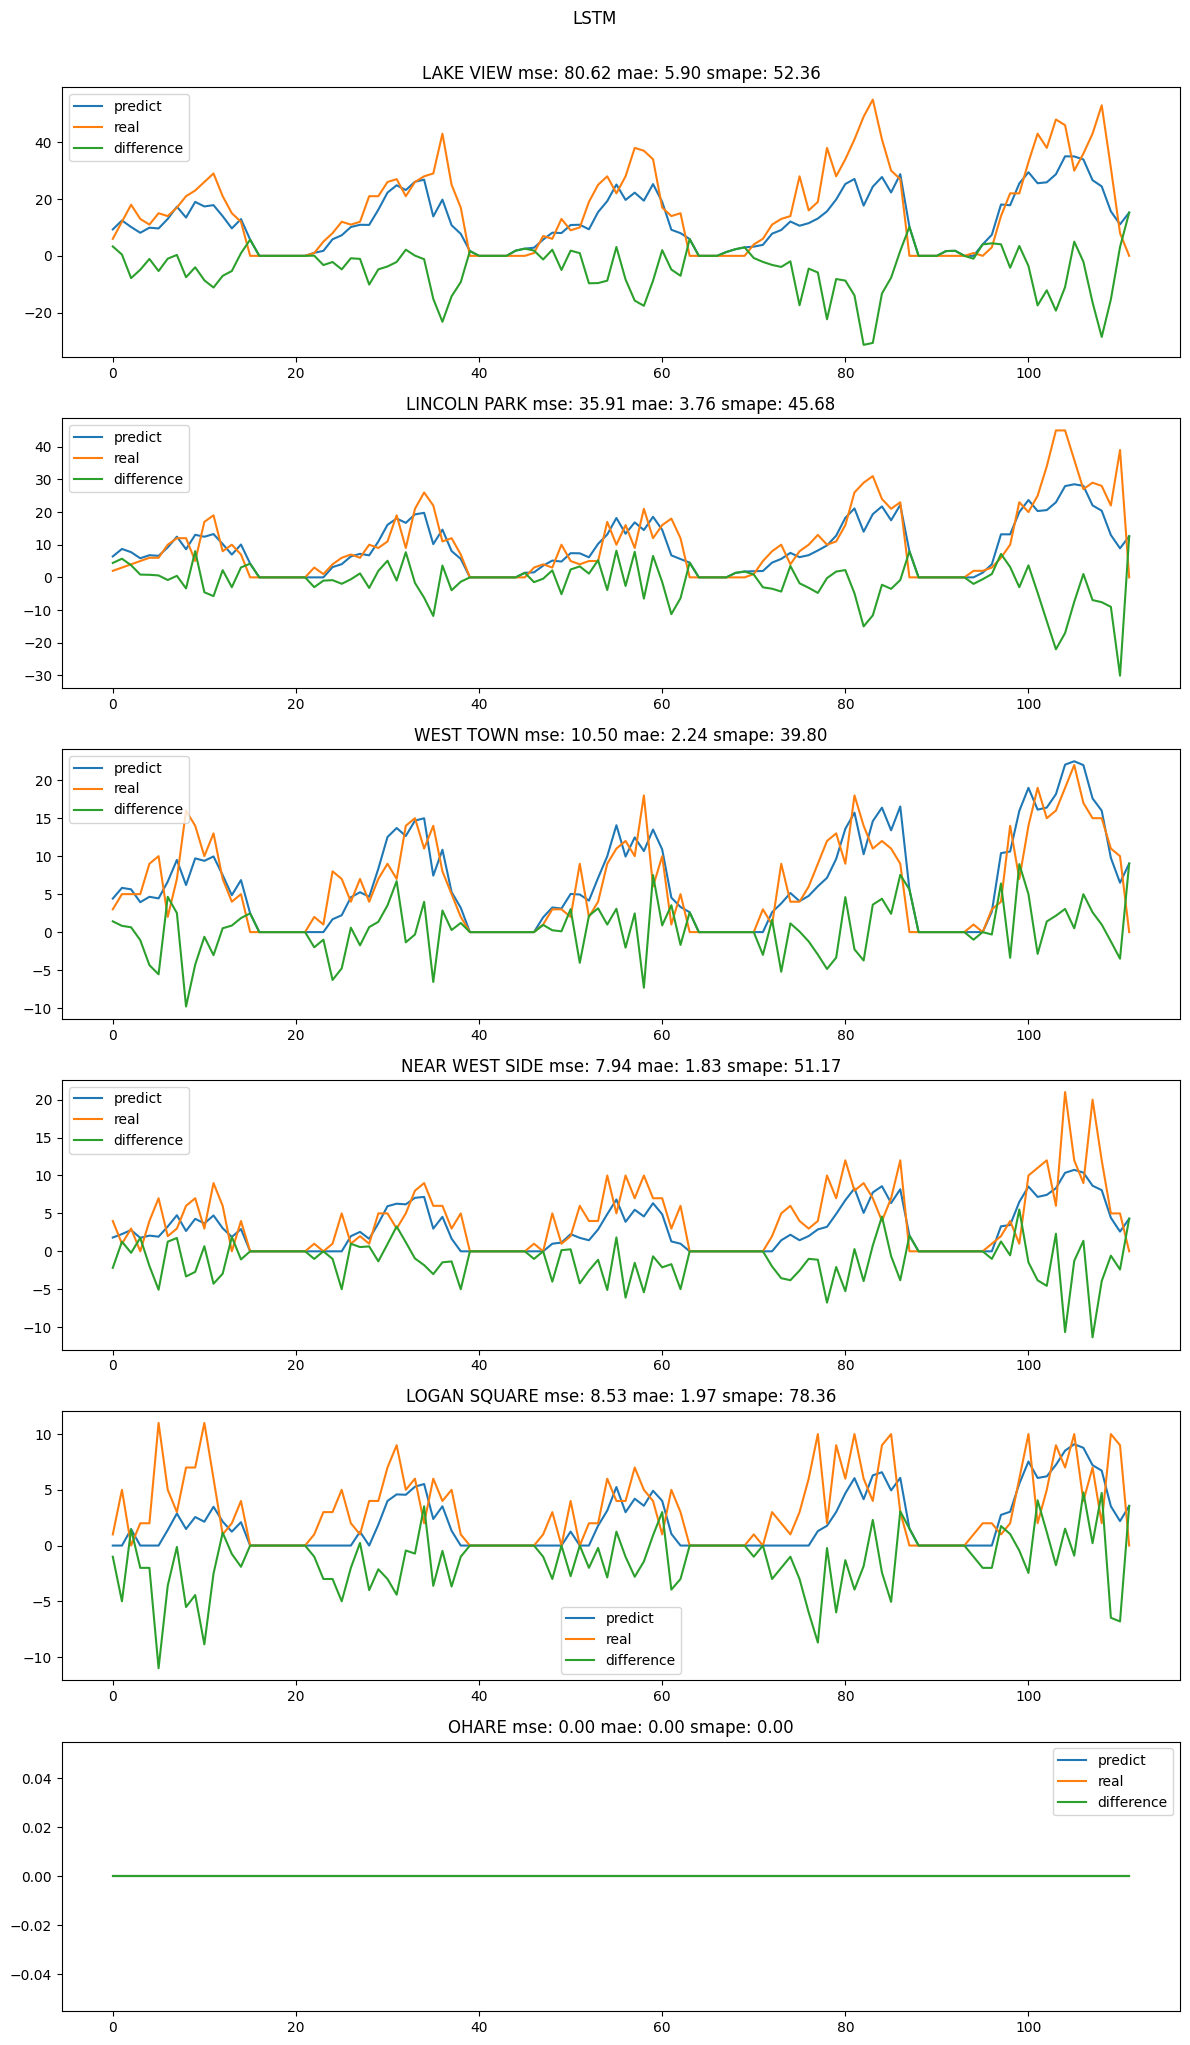

In [53]:
model = keras.models.load_model("_lstm.keras")
model.evaluate(test_dataset)
y_true, y_pred = get_predict_and_true(model, test_dataset)
plot_result(y_true,y_pred,plot_index,"LSTM") 

In [54]:
# gru
inputs = keras.Input(shape=(sequence_length, features.shape[-1]))
x = layers.GRU(64)(inputs)
x = layers.Flatten()(x)
outputs = layers.Dense(output_shape)(x)
model = keras.Model(inputs, outputs)
  
callbacks = [
    keras.callbacks.ModelCheckpoint("_gru.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("_gru.keras") 
mse,mae = model.evaluate(test_dataset)
print(f"Test RMSE {np.sqrt(mse):.2f} Test MAE: {mae:.2f}")

Epoch 1/100
17/17 [==============================] - 2s 50ms/step - loss: 133.2629 - mae: 3.4289 - val_loss: 16.4840 - val_mae: 1.4020
Epoch 2/100
17/17 [==============================] - 1s 31ms/step - loss: 122.5399 - mae: 3.2966 - val_loss: 14.8422 - val_mae: 1.4655
Epoch 3/100
17/17 [==============================] - 1s 31ms/step - loss: 117.1607 - mae: 3.1907 - val_loss: 13.6351 - val_mae: 1.4053
Epoch 4/100
17/17 [==============================] - 1s 32ms/step - loss: 112.8334 - mae: 3.0343 - val_loss: 12.5825 - val_mae: 1.3249
Epoch 5/100
17/17 [==============================] - 1s 32ms/step - loss: 108.9968 - mae: 2.9118 - val_loss: 11.7975 - val_mae: 1.2797
Epoch 6/100
17/17 [==============================] - 1s 31ms/step - loss: 105.5944 - mae: 2.8328 - val_loss: 11.1471 - val_mae: 1.2544
Epoch 7/100
17/17 [==============================] - 1s 31ms/step - loss: 102.4856 - mae: 2.7754 - val_loss: 10.5530 - val_mae: 1.2287
Epoch 8/100
17/17 [==============================] - 1s

4/4 [==============================] - 0s 5ms/step


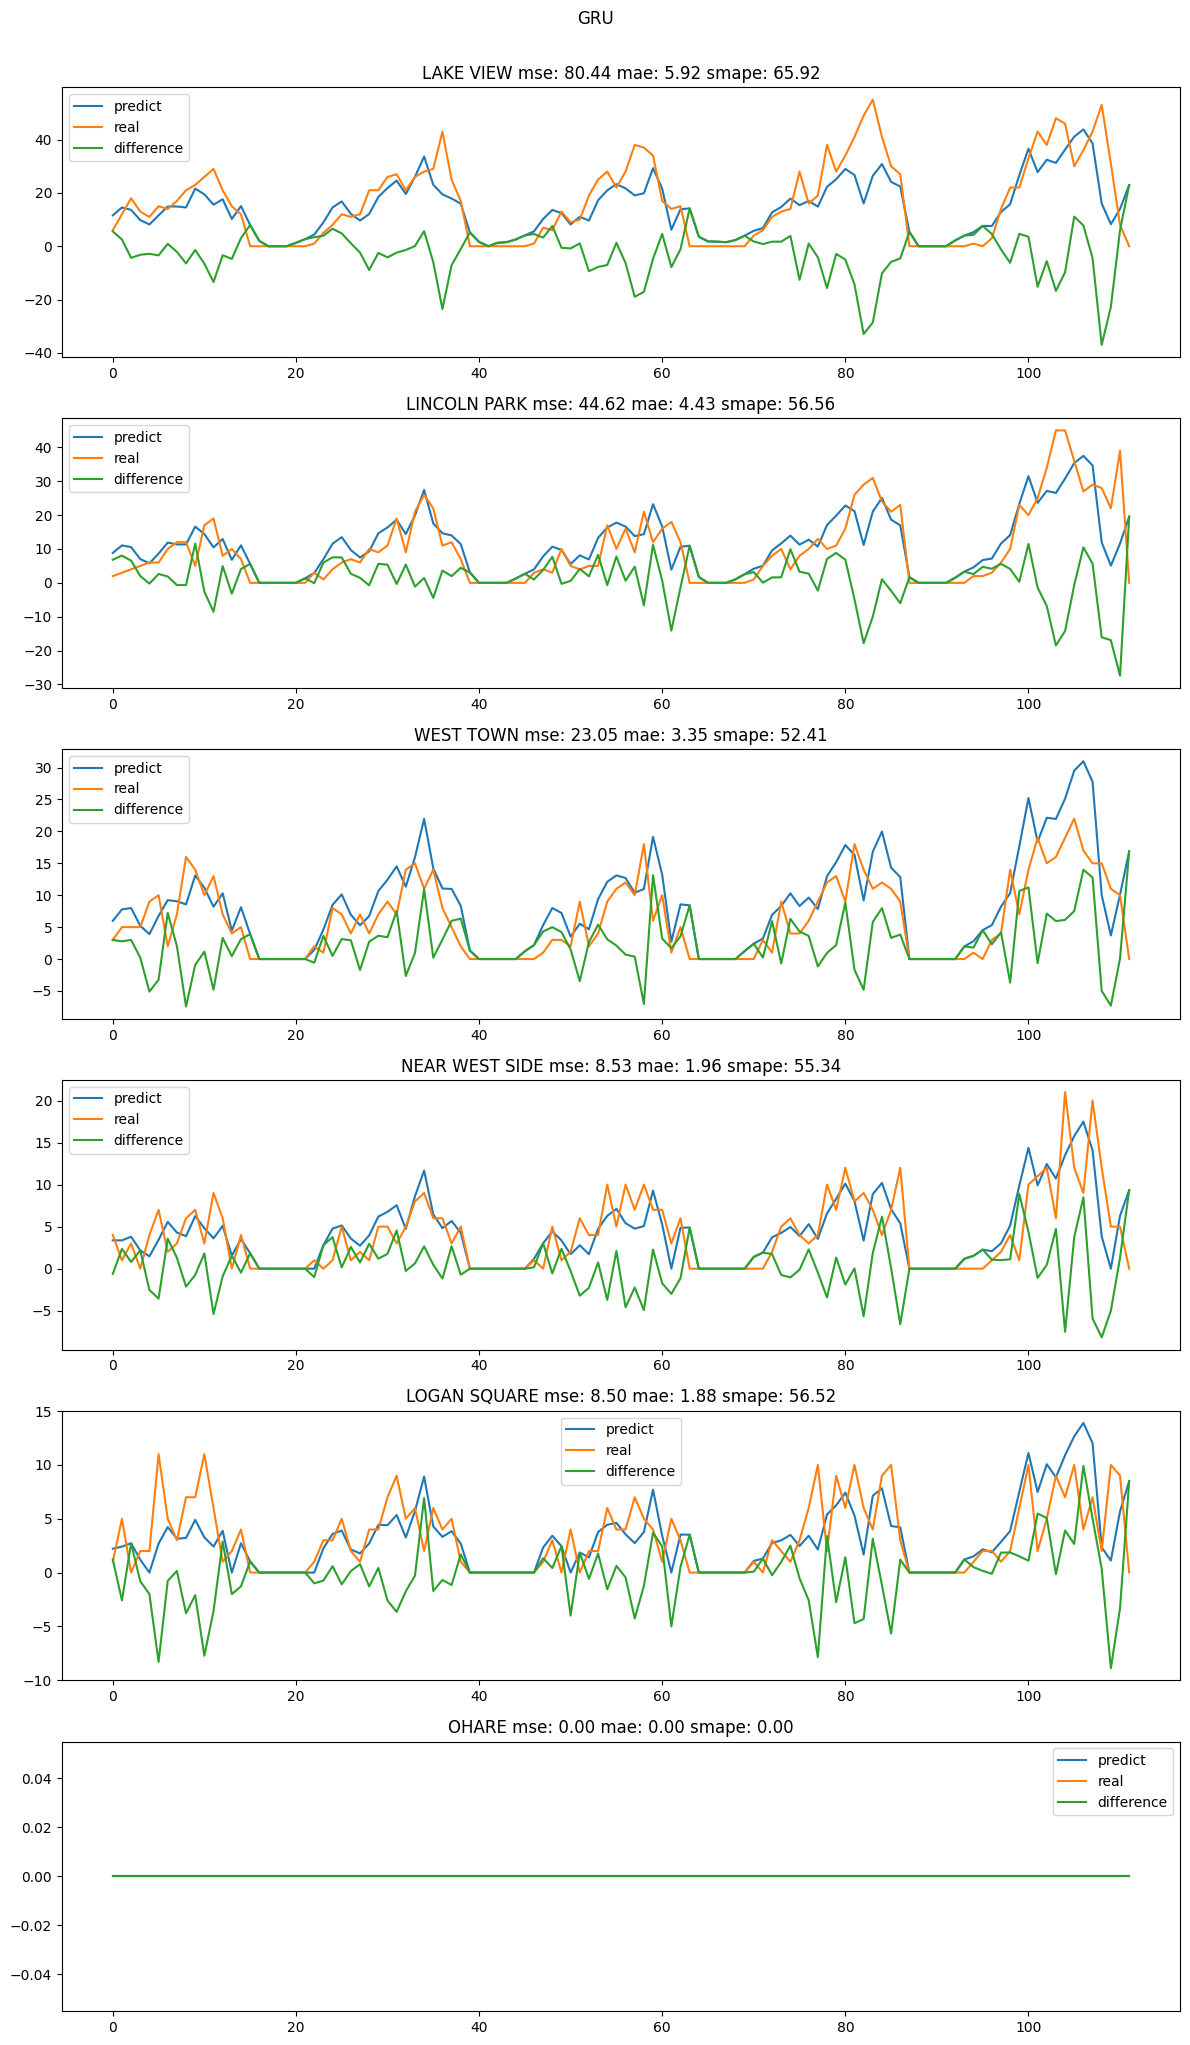

In [55]:
model = keras.models.load_model("_gru.keras")
model.evaluate(test_dataset)
y_true, y_pred = get_predict_and_true(model, test_dataset)
plot_result(y_true,y_pred,plot_index,"GRU") 

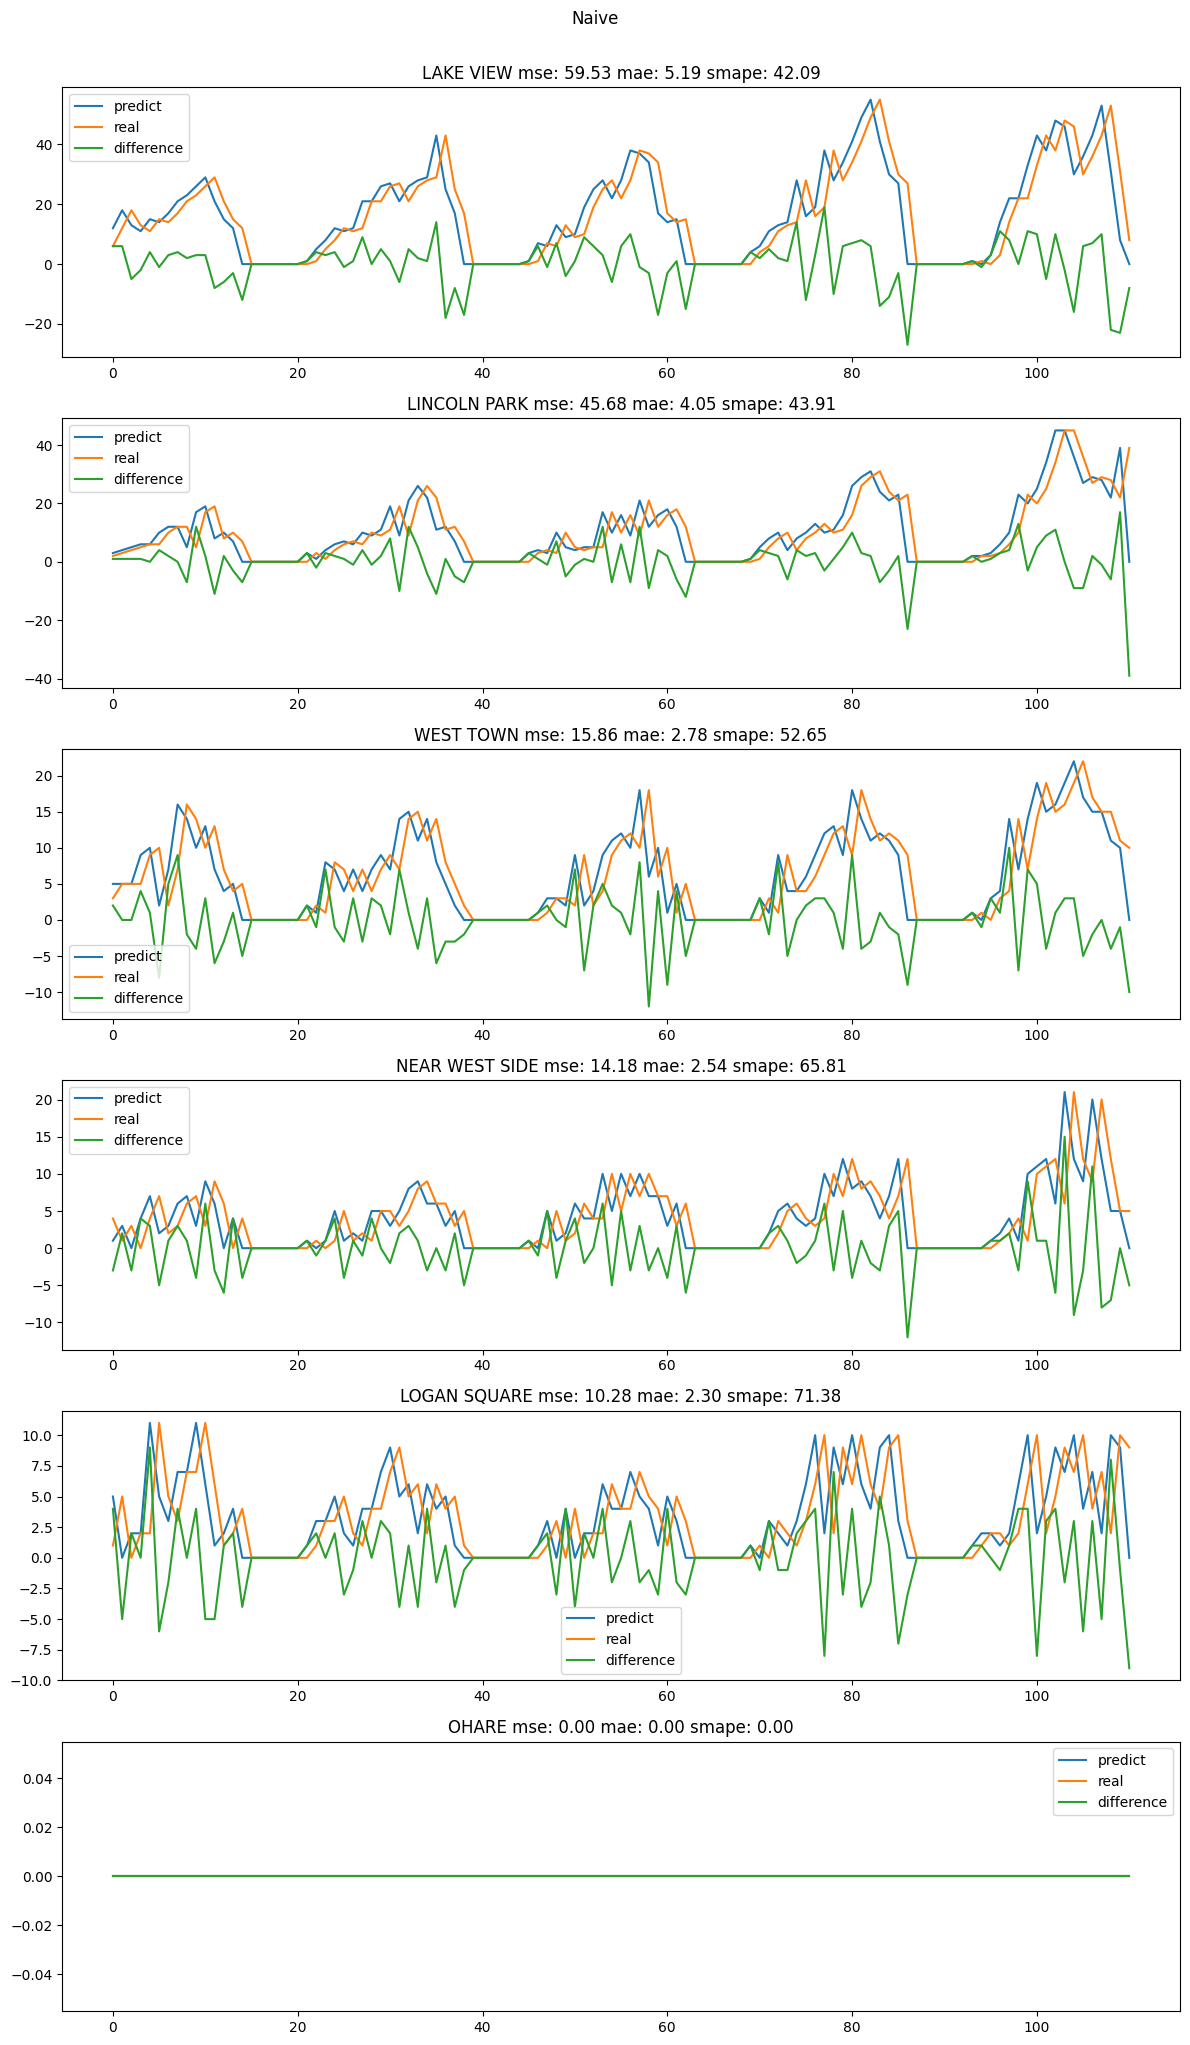

In [56]:
y_true_naive = y_true.numpy()
plot_result(y_true_naive[:-1,:],y_true_naive[1:,:],plot_index,model_name="Naive")
m = cal_metrics(y_true_naive[:-1,:],y_true_naive[1:,:])


In [57]:
for i in m:
    print(i.sum()/len(i))
    

3.18954018954019
0.700947700947701
48.732536671770085
